In [1]:
# stock_tree.ipynb
# Author: Elena Kim

def warn(*args, **kwargs):  # mute sklearn warnings: https://stackoverflow.com/a/33616192
    pass
import warnings
warnings.warn = warn

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


### Helper Functions

In [3]:
# Fetch stock data and prepare features
def fetch_and_prepare_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)  # fetch data for `ticker`
    
    # Extrapolate key stock market indicators
    stock_data['Daily Return'] = stock_data['Close'].pct_change()  # daily returns
    stock_data['30-Day MA'] = stock_data['Close'].rolling(window=30).mean()  # moving average
    stock_data['100-Day MA'] = stock_data['Close'].rolling(window=100).mean()  # moving average
    stock_data['Lagged Close'] = stock_data['Close'].shift(1)  # lagged closing price
    
    stock_data.dropna(inplace=True)
    
    X = stock_data[['30-Day MA', '100-Day MA', 'Lagged Close', 'Daily Return']]  # input features
    y = stock_data['Close']  # target
    
    return stock_data, X, y


In [4]:
# Train Decision Tree and Random Forest models
def train_models(X_train, y_train):
    # decision tree
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)
    
    # random forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    return dt_model, rf_model


In [5]:
def get_preds(models, X_test):
    # decision tree
    dt_model = models.get("Decision Tree")
    y_pred_dt = dt_model.predict(X_test)

    # random forest
    rf_model = models.get("Random Forest")
    y_pred_rf = rf_model.predict(X_test)

    return y_pred_dt, y_pred_rf

def eval_mse(y_test, y_pred_dt, y_pred_rf):
    dt_mse = mean_squared_error(y_test, y_pred_dt)  # decision tree MSE
    rf_mse = mean_squared_error(y_test, y_pred_rf)  # random forest MSE

    return dt_mse, rf_mse

In [6]:
# Plot actual vs predicted prices
def plot_predictions(y_test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual Prices', linewidth=2)
    plt.plot(predictions, label='Predicted Prices', linestyle='--')
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()


### Tesla: initial test

In [7]:
ticker = "TSLA"
start_date = "2020-01-01"
end_date = "2023-01-01"

stock_data, X, y = fetch_and_prepare_data(ticker, start_date, end_date)


[*********************100%***********************]  1 of 1 completed


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
tree_model, forest_model = train_models(X_train, y_train)

In [10]:
models = {"Decision Tree": tree_model, "Random Forest": forest_model}
y_pred_dt, y_pred_rf = get_preds(models, X_test)
mse_tsla_dt, mse_tsla_rf = eval_mse(y_test, y_pred_dt, y_pred_rf)

print(f"decision_tree - MSE: {mse_tsla_dt}")
print(f"random_forest - MSE: {mse_tsla_rf}")


decision_tree - MSE: 24.963812492234204
random_forest - MSE: 11.801086571217098


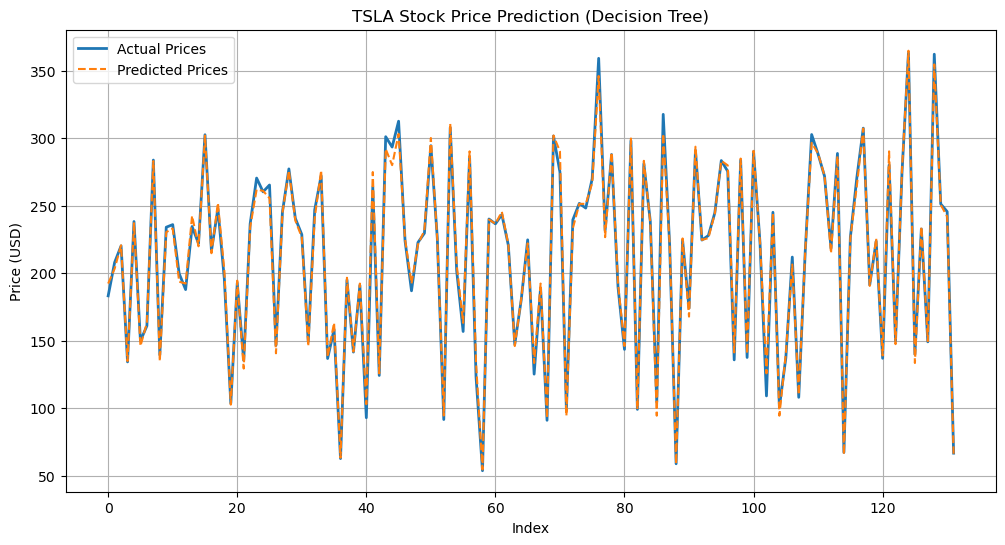

In [11]:
plot_predictions(y_test, y_pred_dt, f"{ticker} Stock Price Prediction (Decision Tree)")

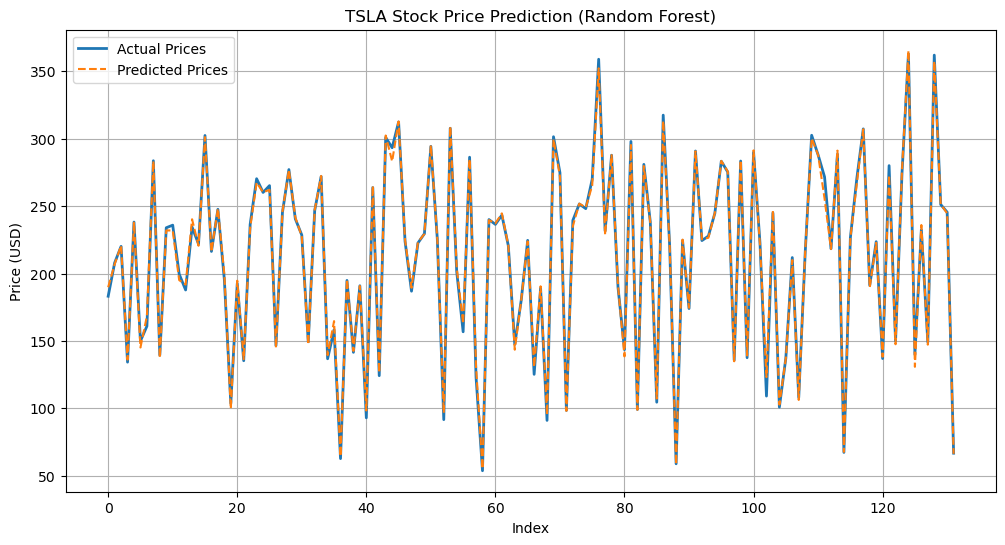

In [12]:
plot_predictions(y_test, y_pred_rf, f"{ticker} Stock Price Prediction (Random Forest)")

While performance looks largely the same through the visualization, the MSEs we achieve are significantly lower than for `TSLA`. This raises questions about the validity of MSE as an evaluation metric across multiple tickers, as "average error" will generally be larger if the range of a specific stock ticker is larger as well.

### Try with Apple

In [13]:
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2023-01-01"

stock_data, X, y = fetch_and_prepare_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
tree_model, forest_model = train_models(X_train, y_train)

In [16]:
models = {"Decision Tree": tree_model, "Random Forest": forest_model}
y_pred_dt, y_pred_rf = get_preds(models, X_test)
mse_aapl_dt, mse_aapl_rf = eval_mse(y_test, y_pred_dt, y_pred_rf)

print(f"decision_tree - MSE: {mse_aapl_dt}")
print(f"random_forest - MSE: {mse_aapl_rf}")

decision_tree - MSE: 2.052258398537753
random_forest - MSE: 1.0269601636371746


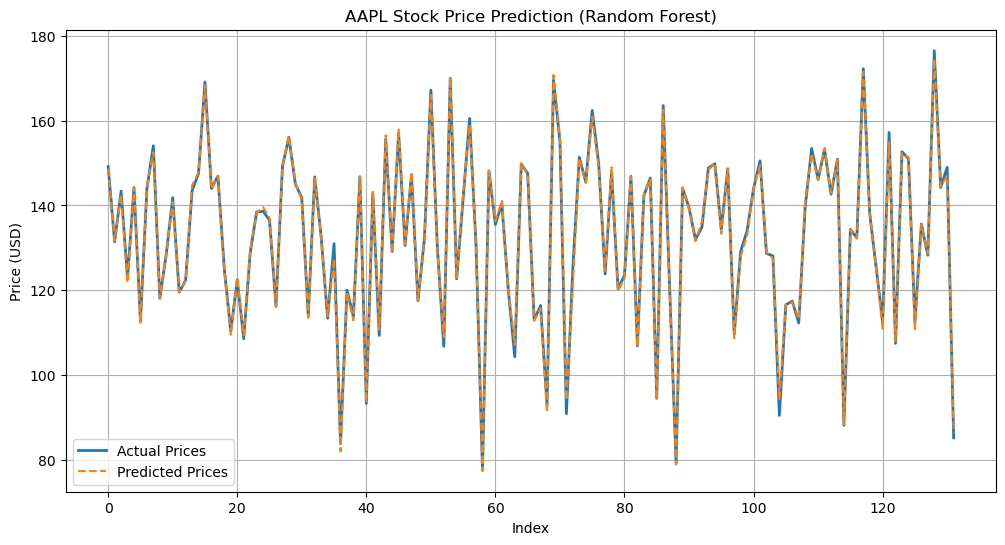

In [17]:
plot_predictions(y_test, y_pred_rf, f"{ticker} Stock Price Prediction (Random Forest)")

From the TSLA and AAPL tests, we observe clearly lower MSE's when evaluating our models (Decision Trees & Random Forests) on AAPL. However, we can't conclusively say that our model is better at predicting the AAPL stock than the TSLA stock, since the lower MSE's could instead be indicative of the higher price range found in TSLA, leading to a greater error (on average).

To test this theory, let's evaluate on a larger scope.

### Train & Evaluate across all SP500 tickers

In [18]:
def train_and_eval_models(ticker, start_date="2020-01-01", end_date="2023-01-01"):
    stock_data, X, y = fetch_and_prepare_data(ticker, start_date, end_date)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tree_model, forest_model = train_models(X_train, y_train)
    models = {"Decision Tree": tree_model, "Random Forest": forest_model}

    y_pred_dt, y_pred_rf = get_preds(models, X_test)
    mse_dt, mse_rf = eval_mse(y_test, y_pred_dt, y_pred_rf)

    # plot_predictions(y_test, results['Random Forest']['predictions'], f"{ticker} Stock Price Prediction (Random Forest)")
    return mse_dt, mse_rf


In [19]:
def scrape_tickers(url):
    table = pd.read_html(url)
    sp500_df = table[0]  # extract tickers from first table

    sp500_tickers = sp500_df['Symbol'].tolist()
    return sp500_tickers

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_tickers = scrape_tickers(url)
print(sp500_tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DV

In [ ]:
dt_total_mse = 0
rf_total_mse = 0

for ticker in sp500_tickers:
    try:
        mse_decision_tree, mse_random_forest = train_and_eval_models(ticker)
    except ValueError as e:
        pass
    dt_total_mse += mse_decision_tree
    rf_total_mse += mse_random_forest

In [21]:
dt_avg_mse = dt_total_mse / len(sp500_tickers)
rf_avg_mse = rf_total_mse / len(sp500_tickers)

print(dt_avg_mse)
print(rf_avg_mse)


15.106407977092864
6.523984962334589


In [22]:
starbucks = yf.Ticker("SBUX")
print(starbucks.info["industry"])

Restaurants


### Train & Evaluate: capture average error by industry

In [ ]:
industry_avg = {}

for t in sp500_tickers:
    try:
        mse_dt, mse_rf = train_and_eval_models(t)

        ticker = yf.Ticker(t)

        if ticker.info["industry"] not in industry_avg:
            industry_avg[ticker.info["industry"]] = [mse_dt, mse_rf]
        else:
            industry_avg[ticker.info["industry"]][0] += mse_dt
            industry_avg[ticker.info["industry"]][1] += mse_rf
    except ValueError as e:
        # print(e)
        pass
    except KeyError as e:
        # print(e)
        pass

In [24]:
industry_avg

{'Conglomerates': [4.50469078752565, 3.405454693565937],
 'Specialty Industrial Machinery': [71.75565334334351, 48.047648191624745],
 'Medical Devices': [27.487042783791175, 14.833428455750287],
 'Drug Manufacturers - General': [73.98019382825127, 65.5148704620678],
 'Information Technology Services': [112.51541218828534, 88.4244969994101],
 'Software - Infrastructure': [101.95239708468209, 55.94954909923809],
 'Semiconductors': [62.924420178911966, 25.293034625966147],
 'Utilities - Diversified': [0.44398892697098413, 0.2801767950899482],
 'Insurance - Life': [2.7962657745884743, 1.6354544466433607],
 'Specialty Chemicals': [48.852921449230266, 32.43616279823405],
 'Travel Services': [718.5667121552549, 366.34786543423365],
 'REIT - Office': [2.2701609484657554, 1.4472211424142907],
 'Medical Instruments & Supplies': [236.0286980651105, 82.68997448535073],
 'Security & Protection Services': [1.7224554798555223, 0.8786523611213595],
 'Utilities - Regulated Electric': [7.140694211061855

These findings can either mean:
1. More lucrative industries will naturally have higher MSEs due to inflated numbers
2. Our models are less effective at predicting outliers.

It seems clear that MSE is not a strong enough descriptor of the accuracy of our model in predicting a specific ticker, so let's try Mean Absolute Percentage Error (MAPE). This will ideally be more effective at evaluating across industries with different scales.

In [25]:
def eval_mape(y_test, y_pred_dt, y_pred_rf):
    y_test, y_pred_dt, y_pred_rf = np.array(y_test), np.array(y_pred_dt), np.array(y_pred_rf)

    dt_mape = np.mean(np.abs((y_test - y_pred_dt) / np.clip(np.abs(y_test), 1e-10, None))) * 100
    rf_mape = np.mean(np.abs((y_test - y_pred_rf) / np.clip(np.abs(y_test), 1e-10, None))) * 100

    return dt_mape, rf_mape

In [26]:
# Redefine function to add evaluation method parameter compatibility
def train_and_eval_models(ticker, start_date="2020-01-01", end_date="2023-01-01", eval='mse'):
    stock_data, X, y = fetch_and_prepare_data(ticker, start_date, end_date)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tree_model, forest_model = train_models(X_train, y_train)
    models = {"Decision Tree": tree_model, "Random Forest": forest_model}

    # plot_predictions(y_test, results['Random Forest']['predictions'], f"{ticker} Stock Price Prediction (Random Forest)")

    y_pred_dt, y_pred_rf = get_preds(models, X_test)
    if eval == 'mse':
        mse_dt, mse_rf = eval_mse(y_test, y_pred_dt, y_pred_rf)
        return mse_dt, mse_rf
    elif eval == 'mape':
        mape_dt, mape_rf = eval_mape(y_test, y_pred_dt, y_pred_rf)
        return mape_dt, mape_rf
    
    return None

In [ ]:
industry_avg = {}

for t in sp500_tickers:
    try:
        mape_dt, mape_rf = train_and_eval_models(t, eval='mape')

        ticker = yf.Ticker(t)

        if ticker.info["industry"] not in industry_avg:
            industry_avg[ticker.info["industry"]] = [mape_dt, mape_rf]
        else:
            industry_avg[ticker.info["industry"]][0] += mape_dt
            industry_avg[ticker.info["industry"]][1] += mape_rf
    except ValueError as e:
        # print(e)
        pass
    except KeyError as e:
        # print(e)
        pass

industry_avg = {key: [float(value) for value in values] for key, values in industry_avg.items()}
print(industry_avg)

Final Observations:
1. Random Forests generally outperform Decision Trees, as they generally face reduced overfitting and can capture more nuanced relationships in data
2. We see an improvement with MAPE as our evaluation metric, as industries with low MSE can still exhibit high MAPE. For example: for 'Utilities - Diversified', MSE is 0.444 (low) but MAPE is 37.49%, indicating that while the absolute error is small, the relative error compared to small target values is significant. The opposite is also possible.
3. Some industries are consistently difficult to predict in both absolute and relative terms. For example, 'Software - Infrastructure' exhibits an MSE of 101.95 and MAPE of 348.50%, indicating that decision trees and random forests struggle with regression data in these contexts. With larger ranges and greater variance, the splits that occur in Decision Trees may not effectively capture the complex patterns within the data. While random forests improve robustness by averaging predictions across multiple trees, they can still inherit the limitations of individual trees, especially in datasets with complex, non-linear dependencies.

Next Steps:
1. Keep exploring evaluation methods to find one that can accurate depict model performance across different scales, such as RMSLE, NMSE, etc
2. Explore neural networks (i.e. LSTMs, RNNs) to better capture more complex relationships in data